In [43]:
import meep as mp
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

class Waveguide():

    def __init__(self,normalised=False,**kwargs):
        
        self.file=kwargs.get('file',None)
        if self.file is None:
            self.file=str(datetime.now().time())+str(datetime.now().date())
        
        self.current_dir=Path.cwd()    
        self.a=kwargs.get('a',0.44)
        self.r=kwargs.get('r',0.35)*self.a
        self.h=kwargs.get('h',0.22)

        self.dpml=kwargs.get('dpml',1.5)
        self.Nx=kwargs.get('Nx',8)
        self.Sx=kwargs.get('Sx',4)
        self.Ny=kwargs.get('Ny',8)
        self.p=kwargs.get('p',1.07)
        self.lwvg=kwargs.get('lwvg',8)*self.a
        self.padding=kwargs.get('padding',0.5)
        self.wwvg=kwargs.get('wwvg', 1)    # in units of sqrt(3)*a
        self.norm_saved=False
        
        
            
    def _triangle(self,Nx,Ny,x,y,a=1,r=0.3,p=1,invert=False,flip=False):

        '''
        Function to create a triangular lattice of air holes at x,y
        '''

        geometry=[]
        inv=1
        flp=1
        if invert==True:
          inv=-1
        if flip==True:
          flp=-1
        for i in range(Ny):
          off=0

          if i%2!=0:

            off=a*(1/2)*p*flp


            l=Nx-1
          else:
            off=0
            l=Nx
          for j in range(l):

            step=a*j*p*flp


            geometry.append(mp.Cylinder(r, center=mp.Vector3(off+x+step,y+inv*i*a*np.sqrt(3)/2)))



        return geometry


    def _line(self,N,x,y,r,a,flip=False):
        '''
        function to create a line of N holes at starting position x,y
        '''


        flp=1
        if flip==True:
          flp=-1
        geometry=[]
        for i in range(N):
          geometry.append(mp.Cylinder(r,center=mp.Vector3(x+flp*i*a,y)))
        return geometry

    def _waveguide(self,Nx,Ny,x,y,defect_width=1,a=1,r=0.3,p=1,flip=False):


        '''
        Function to produce a W1 waveguide at x,y.
        '''
        r=self.r
        geometry1=self._triangle(Nx,Ny,x,y+defect_width*a*np.sqrt(3)/2,a,r,p=p,flip=flip)
        geometry2=self._triangle(Nx,Ny,x,y-defect_width*a*np.sqrt(3)/2,a,r,p=p,flip=flip,invert=True)


        geometry=geometry1+geometry2

        return geometry



    def make_lat_geom(self,offset1=0,offset2=0, mirror=True, stepper=True):

      Si=mp.Medium(index=3.45)
      self.geometry=[]

      x_slow=-((self.Nx-1)/2)*self.a
     
      
      x_fast=x_slow-self.a*self.p*(self.Sx+1)/2
      
      if self.Sx==0:
        self.x_waveguide=-x_slow
      else:
        self.x_waveguide=-x_fast+self.a

      self.cell_z=2*3*self.h+2*self.dpml
      self.cell_x= self.Nx*self.a+2*self.dpml+self.lwvg+2*self.Sx*self.a*self.p
      self.cell_y=2*self.Ny*self.a*np.sqrt(3)/2+self.a*np.sqrt(3)+2*self.dpml+self.padding*self.a
      self.cell=mp.Vector3(self.cell_x,self.cell_y,self.cell_z)
      for i in range(self.Ny):
        if i%2==0:
          N=self.Nx
          c=0
          S=self.Sx        
        else:
          N=self.Nx-1
          c=self.a/2
          S=self.Sx-1
        
        if i==0:
          offset=offset1
        elif i==1:
          offset=offset2
        else:
          offset=0
        
        self.geometry=self.geometry+self._line(N,x_slow+c,i*self.a*np.sqrt(3)/2+(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a)
        self.geometry=self.geometry+self._line(N,x_slow+c,-i*self.a*np.sqrt(3)/2-(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a)
        
        
        
        if stepper==True:
          self.geometry=self.geometry+self._line(S,x_slow-c,i*self.a*np.sqrt(3)/2+(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a*self.p,flip=True)
          self.geometry=self.geometry+self._line(S,x_slow-c,-i*self.a*np.sqrt(3)/2-(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a*self.p,flip=True)

          self.geometry=self.geometry+self._line(S,-x_slow+c,i*self.a*np.sqrt(3)/2+(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a*self.p)
          self.geometry=self.geometry+self._line(S,-x_slow+c,-i*self.a*np.sqrt(3)/2-(self.wwvg+offset)*self.a*np.sqrt(3)/2, self.r, self.a*self.p)
          
        
      if mirror==True:
          self.geometry=self.geometry+self.asymmetric_mirror(x_slow+self.a*1/2,-x_slow-self.a*1/2,1,1)    
        
      self.geometry.insert(0,mp.Block(size=mp.Vector3(2*self.x_waveguide,self.cell_y,self.h),material=Si))
      self.geometry.insert(0,mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si))

      self.ref_geometry=[mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si)]

      self.boundary=[mp.PML(self.dpml)]
      self.taper_geom=True


    def asymmetric_mirror(self,x1,x2,N1=1,N2=4):
      geometry=[]
      geometry+=self._line(N1,x1,0,self.r,self.a)
      geometry+=self._line(N2,x2,0,self.r,self.a,flip=True)
      return geometry

    def make_long_geom(self, offset1, offset2, mirror=True):
      Si=mp.Medium(index=3.45)
      self.geometry=[]

      x_slow=-((self.Nx-1)/2)*self.a
      
      self.x_waveguide=-x_slow
      self.cell_z=2*3*self.h+2*self.dpml
      self.cell_x= self.Nx*self.a+2*self.dpml+self.lwvg
      self.cell_y=2*self.Ny*self.a*np.sqrt(3)/2+self.a*np.sqrt(3)+2*self.dpml+self.padding*self.a
      self.cell=mp.Vector3(self.cell_x,self.cell_y,self.cell_z)
      for i in range(self.Ny):
        if i%2==0:
          N=self.Nx
          c=0
        else:
          N=self.Nx-1
          c=self.a/2
        if i==0:
          offset=offset1
        elif i==1:
          offset=offset2
        else:
          offset=0
        self.geometry=self.geometry+self._line(N,x_slow+c+offset,i*self.a*np.sqrt(3)/2+(self.wwvg)*self.a*np.sqrt(3)/2, self.r, self.a)
        self.geometry=self.geometry+self._line(N,x_slow+c+offset,-i*self.a*np.sqrt(3)/2-(self.wwvg)*self.a*np.sqrt(3)/2, self.r, self.a)

        
        if mirror==True:
          self.geometry=self.geometry+self.asymmetric_mirror(x_slow+self.a*1/2,-x_slow-self.a*1/2,1,1)

        self.geometry.insert(0,mp.Block(size=mp.Vector3(-2*x_slow+self.a/2,self.cell_y,self.h),material=Si))
        self.geometry.insert(0,mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si))

        self.ref_geometry=[mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si)]

        self.boundary=[mp.PML(self.dpml)]
        self.taper_geom=True



    def make_taper_geom(self,a1=1,a2=1, offset1=0, offset2=0):
        self.a1=a1
        self.a2=a2


        Si=mp.Medium(index=3.45)

        x_slow=-(self.Nx/2-1/2)*self.a
        if self.Sx==0:
            x_waveguide=x_slow-self.a*(a1+a2)
        else:
            x_waveguide=x_slow-(self.Sx-1/2)*self.p*self.a-self.a*(a1+a2)

        self.x_waveguide=-x_waveguide
        # Size of cell
        self.cell_z=2*3*self.h+2*self.dpml
        self.cell_x= self.Nx*self.a+2*self.dpml+2*self.Sx*self.a*self.p+2*self.a*(a1+a2)+self.lwvg
        self.cell_y=2*self.Ny*self.a*np.sqrt(3)/2+self.a*np.sqrt(3)+2*self.dpml+self.padding*self.a
        self.cell=mp.Vector3(self.cell_x,self.cell_y,self.cell_z)



        self.geometry=self._waveguide(self.Nx,self.Ny,x_slow,0,a=self.a)
        self.geometry+=self._waveguide(2,self.Ny,x_slow,0,a=self.a,p=a1,flip=True)
        self.geometry+=self._waveguide(2,self.Ny,-x_slow,0,a=self.a,p=a1,flip=False)
        self.geometry+=self._waveguide(2,self.Ny,x_slow-self.a*a1,0,a=self.a,p=a2,flip=True)
        self.geometry+=self._waveguide(2,self.Ny,-x_slow+self.a*a1,0,p=a2,a=self.a,flip=False)

        self.geometry+=self._waveguide(self.Sx,self.Ny,x_slow-self.a*(a1+a2),0,p=self.p,a=self.a,flip=True)
        self.geometry+=self._waveguide(self.Sx,self.Ny,-x_slow+self.a*(a1+a2),0,p=self.p,a=self.a)

        self.geometry+=self.asymmetric_mirror(x_slow-self.a*(a1+a2)+self.a*1/2,-x_slow+self.a*(a1+a2)-self.a*1/2)



        self.geometry.insert(0,mp.Block(size=mp.Vector3(-2*x_waveguide,self.cell_y,self.h),material=Si))
        self.geometry.insert(0,mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si))

        self.ref_geometry=[mp.Block(size=mp.Vector3(mp.inf,self.a*self.wwvg*np.sqrt(3),self.h),material=Si)]

        self.boundary=[mp.PML(self.dpml)]
        self.taper_geom=True



    def simulate_taper_geom(self,a1=1,a2=1,fcen=1/1.5365 ,df=0.2, nfreq=10000,pos=[0,0,0],**kwargs):


        self.resolution=kwargs.get('resolution',12)
        self.fcen=fcen
        self.df=df
        self.nfreq=nfreq

        mp.verbosity(0)

        px=pos[0]
        py=pos[1]
        pz=pos[2]

        refl=mp.FluxRegion(center=mp.Vector3(-self.x_waveguide-3*self.a,0,0), size=mp.Vector3(0,2*self.wwvg*self.a*np.sqrt(3),2*self.h))

        trans=mp.FluxRegion(center=mp.Vector3(+self.x_waveguide+2*self.a,0,0), size=mp.Vector3(0,2*self.wwvg*self.a*np.sqrt(3),2*self.h))

        sources = [mp.EigenModeSource(src=mp.GaussianSource(wavelength=1/fcen, fwidth=df),
                                  center=mp.Vector3(-self.x_waveguide-2*self.a ,0, 0),
                                  size=mp.Vector3(0, 3 * self.a*np.sqrt(3)*self.wwvg, 3 * self.h),
                                  eig_parity=mp.ODD_Y + mp.EVEN_Z,
                                  eig_band=1,
                                  eig_match_freq=True)]



        self.sim=mp.Simulation(cell_size=self.cell,
                          geometry=self.geometry,
                          boundary_layers=self.boundary,
                          sources=sources,
                          default_material=mp.air,
                          resolution=self.resolution)

        self.refl_plane=self.sim.add_flux(self.fcen,self.df,self.nfreq,refl)

        self.trans_plane=self.sim.add_flux(self.fcen,self.df,self.nfreq,trans)

        self.ref_sim=mp.Simulation(cell_size=self.cell,
                          geometry=self.ref_geometry,
                          boundary_layers=self.boundary,
                          sources=sources,
                          default_material=mp.air,
                          resolution=self.resolution)

        self.straight_refl_plane=self.ref_sim.add_flux(self.fcen,self.df,self.nfreq,refl)

        self.straight_trans_plane=self.ref_sim.add_flux(self.fcen,self.df,self.nfreq,trans)

        self.animate = mp.Animate2D(self.sim,fields=mp.Ey,
                       realtime=False, normalize=True,
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

        




    def plot_geom(self, save=False):

        self.volz=mp.Volume(size=mp.Vector3(self.cell_x,self.cell_y))
        volx=mp.Volume(size=mp.Vector3(0,self.cell_y,self.cell_z))
        voly=mp.Volume(size=mp.Vector3(self.cell_x,0,self.cell_z))

        
        current_dir=Path.cwd()
        
        self.sim.plot2D(output_plane=self.volz)
       
        plt.show()
        if save==True:
            plt.savefig(current_dir/f'plot_N_{self.Nx}.png')
        self.sim.plot2D(output_plane=volx)
        plt.show()
        
        self.sim.plot2D(output_plane=voly)

    
    def transmittance(self,t1=40,t2=40 ):


        
        if self.norm_saved==False:


            self.ref_sim.run(until_after_sources=t1)
            
            self.norm_saved=True

            
            
            path=self.current_dir/self.file
            path.mkdir(exist_ok=True)
                
            
            try: 
                #self.ref_sim.save_flux(current_dir/'BulkReflection_t1_{t1}', self.straight_refl_plane)
                #self.ref_sim.save_flux(current_dir/'BulkTransmit_t1_{t1}', self.straight_trans_plane)
                
                
                
                flux_freqs = np.array(mp.get_flux_freqs(self.straight_refl_plane))
                
                tran_flux=mp.get_fluxes(self.straight_trans_plane)
                ref_flux=mp.get_fluxes(self.straight_refl_plane)
                dframe = pd.DataFrame({"Frequency": flux_freqs, "Normalised_transmission": tran_flux, "Reflection Normalisation": ref_flux})
                
                dframe.to_csv(path/f"normalise_f{self.fcen}_df{self.df}_N_{self.Nx}.csv",index=False)
            
            except:
                print('error saving')

        
            self.straight_refl_data=self.ref_sim.get_flux_data(self.straight_refl_plane)
            self.straight_trans_flux=mp.get_fluxes(self.straight_trans_plane)

        
            self.straight_refl_flux=mp.get_fluxes(self.straight_refl_plane)

            self.sim.load_minus_flux_data(self.refl_plane,self.straight_refl_data)

        else:

            current_dir=Path.cwd()
            file=Path.cwd()/ f'normalise_f{self.fcen}_df{self.df}_N_{self.Nx}.csv'
            
            if file.is_file():
                dframe=pd.read_csv(f'normalise_f{self.fcen}_df{self.df}_N_{self.Nx}.csv',index=False)
                
                self.sim.load_minus_flux(fname=reflection_file, flux=self.refl_plane)
        
                self.sim.load_flux(fname=transmission_file,flux=self.straight_trans_plane)
            

            if reflection_file.is_file()==False or transmission_file.is_file()==False:
            
                print('File not Found')
            else:
                self.sim.load_minus_flux(fname=reflection_file, flux=self.refl_plane)
        
                self.sim.load_flux(fname=transmission_file,flux=self.straight_trans_plane)
            
        
        self.sim.run(mp.in_volume(self.volz,mp.at_every(1,self.animate)), until_after_sources=t2)



        self.tran_flux = mp.get_fluxes(self.trans_plane)


        self.refl_flux = mp.get_fluxes(self.refl_plane)

        self.flux_freqs = mp.get_flux_freqs(self.refl_plane)

        
        self.animate.to_gif(fps=20,filename=path/f'Reflection_{self.a}_r_{self.r}_{self.Nx}.gif')  
      

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def detect_dips(spectrum, threshold=0.2):
    """
    Detect dips in a spectrum.

    Parameters:
    - spectrum: 1D array representing the spectrum.
    - threshold: The threshold for considering a point as a dip.

    Returns:
    - dip_indices: Indices of the detected dips.
    """

    # Find local minima in the spectrum
    minima_indices = argrelextrema(spectrum, np.less)[0]

    # Filter minima based on the threshold
    dip_indices = minima_indices[spectrum[minima_indices] < threshold]

    return dip_indices

def get_FSR(N,a,freqs, spectrum ,threshold=0.2):
    dip_indices=detect_dips(spectrum, threshold)
    freqs=np.array(freqs)
    dips=freqs[dip_indices]
    fsr=np.array([dips[i+1]-dips[i] for i in range(len(dips)-1)])
    l=a*N
    c=3
    return c/(2*l*fsr)


In [44]:
a=0.442
W1=Waveguide(p=1.1,Sx=5, Nx=25, Ny=6,a=a)



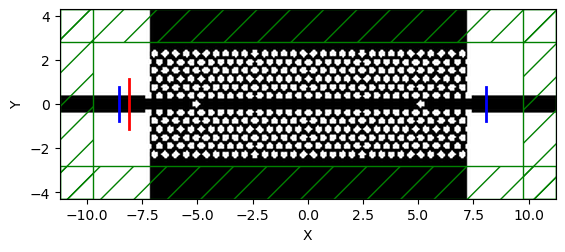

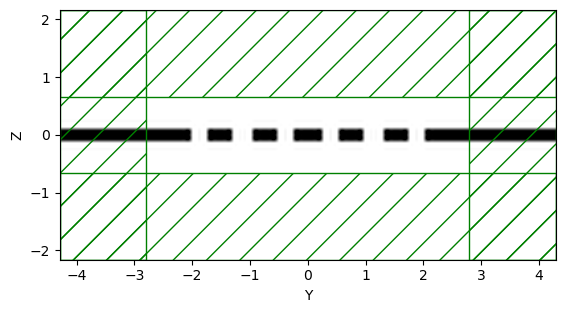

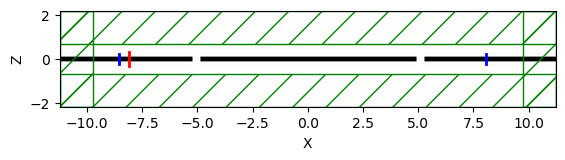

In [38]:
W1.make_lat_geom(offset1=0.0,offset2=0, stepper=True)

W1.simulate_taper_geom(resolution=14)
W1.sim.eps_averaging = True
W1.plot_geom()

In [40]:
W1.transmittance(t1=200,t2=1500)

FloatProgress(value=0.0, description='0% done ', max=250.0)

FloatProgress(value=0.0, description='0% done ', max=1550.0)

In [47]:
wl = []
Rs = []
Ts = []
for i in range(len(W1.flux_freqs)):
  wl = np.append(wl, 1/W1.flux_freqs[i])
  Rs = np.append(Rs,(-W1.refl_flux[i])/W1.straight_trans_flux[i])
  Ts = np.append(Ts,W1.tran_flux[i]/W1.straight_trans_flux[i])


plt.figure()
plt.plot(wl,Rs,label='reflectance')
#plt.plot(wl,Ts,label='transmittance')
#plt.plot(wl,1-Rs-Ts,label='loss')

plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")

#plt.plot(v.straight_trans_flux)
#plt.plot(np.array(v.straight_trans_flux))
idx=detect_dips(Rs, threshold=0.7
               )
plt.scatter(np.array(wl)[idx],np.array(Rs)[idx], marker='x')
#plt.xlim(1.4,1.6)
plt.show()


AttributeError: 'Waveguide' object has no attribute 'flux_freqs'

In [ ]:
threshold=0.7
idx=detect_dips(Rs, threshold=threshold)

fsr=get_FSR(15,0.422,W1.flux_freqs,Rs,threshold=threshold)

plt.plot(np.array(wl)[idx][:-1], fsr, marker='x')
plt.xlim(1.35,1.56)
plt.ylim(0,100)